In [1]:
import pandas as pd
import numpy as np
import ujson
from datetime import datetime
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import sys

sys.path.append("../functions")

from latlng2pentad import latlng2pentad
from pentad2latlng import pentad2latlng

In [149]:
ac = pd.read_csv(
    "/Users/rafnuss/Library/CloudStorage/Box-Box/eBird2ABAP/data/ABAP/1_s2_fp_headers.csv",
    usecols=[
        "card",
        "startdate",
        "enddate",
        "starttime",
        "pentad",
        "observer",
        "totalhours",
        "totalspp",
    ],
    parse_dates=["startdate", "enddate"],
    dayfirst=True,
)
ac.drop(["starttime", "enddate"], axis=1, inplace=True)
ac["lat"], ac["lon"] = pentad2latlng(ac["pentad"])

In [150]:
ar = pd.read_csv(
    "/Users/rafnuss/Library/CloudStorage/Box-Box/eBird2ABAP/data/ABAP/1_s2_fp_records.csv",
    usecols=[
        "card",
        "ADU",
        "SEQ",
    ],
)
ar = ar[ar["card"].isin(ac["card"])]

In [153]:
a = pd.merge(ar, ac, how="left")
a

,card,ADU,SEQ,startdate,enddate,starttime,pentad,observer,totalhours,totalspp,lat,lon
0,2555_2755_001691_20070701,242,1,2007-07-01,2007-07-01,07:00,2555_2755,1691.0,4,49,-25.958333,27.958333
1,2555_2755_001691_20070701,245,2,2007-07-01,2007-07-01,07:00,2555_2755,1691.0,4,49,-25.958333,27.958333
2,2555_2755_001691_20070701,707,3,2007-07-01,2007-07-01,07:00,2555_2755,1691.0,4,49,-25.958333,27.958333
3,2555_2755_001691_20070701,522,4,2007-07-01,2007-07-01,07:00,2555_2755,1691.0,4,49,-25.958333,27.958333
4,2555_2755_001691_20070701,314,5,2007-07-01,2007-07-01,07:00,2555_2755,1691.0,4,49,-25.958333,27.958333
...,...,...,...,...,...,...,...,...,...,...,...,...
20158925,2400_2900_022427_20240815,521,24,2024-08-15,2024-08-16,15:51:32,2400_2900,22427.0,3,26,-24.041667,29.041667
20158926,2400_2900_022427_20240815,4142,25,2024-08-15,2024-08-16,15:51:32,2400_2900,22427.0,3,26,-24.041667,29.041667
20158927,2400_2900_022427_20240815,780,26,2024-08-15,2024-08-16,15:51:32,2400_2900,22427.0,3,26,-24.041667,29.041667
20158928,2520_3150_010916_20240818,576,104,2024-08-18,2024-08-19,05:36:12,2520_3150,10916.0,8,101,-25.375000,31.875000


In [169]:
ec = pd.read_csv(
    "../export/ebd_AFR_relJul-2024_20240829_224929_cards.csv",
    parse_dates=["OBSERVATION DATETIME_min", "OBSERVATION DATETIME_max"],
).rename(columns={"CARD": "card", "OBSERVATION DATE": "startdate", "PENTAD": "pentad"})
ec["totalhours"] = ec["DURATION MINUTES_sum"] / 60
ec["lat"], ec["lon"] = pentad2latlng(ec["pentad"])
ec.drop(
    ["OBSERVATION DATETIME_min", "OBSERVATION DATETIME_max", "DURATION MINUTES_sum"],
    axis=1,
    inplace=True,
)
ec.drop(["EFFORT DISTANCE KM_sum"], axis=1, inplace=True)

In [171]:
er = pd.read_csv(
    "../export/ebd_AFR_relJul-2024_20240829_224930_records.csv",
).rename(columns={"CARD": "card"})

In [174]:
e = pd.merge(er, ec, how="left")

In [179]:
totalspp = er.groupby("card").size().reset_index(name="totalspp")
ec = ec.merge(totalspp, on="card", how="left")

## Illustration


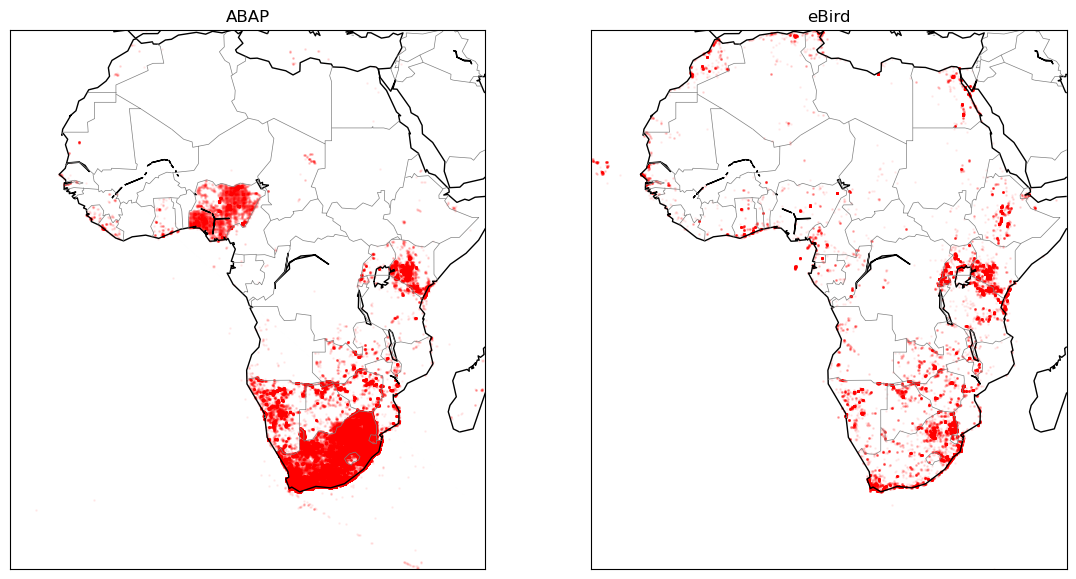

In [85]:
def plot_map(ax, c, title):
    m = Basemap(
        llcrnrlat=np.min(ec["lat"]),
        urcrnrlat=np.max(ec["lat"]),
        llcrnrlon=np.min(ec["lon"]),
        urcrnrlon=np.max(ec["lon"]),
        ax=ax,
    )
    m.drawcoastlines()
    m.drawcountries(color="gray")
    m.scatter(c["lon"], c["lat"], latlon=True, s=1, c="red", marker="o", alpha=0.05)
    ax.set_title(title)


fig, axs = plt.subplots(1, 2, figsize=(15, 7))

# Plot both maps
plot_map(axs[0], ac, "ABAP")
plot_map(axs[1], ec, "eBird")

plt.subplots_adjust(wspace=0)
plt.show()

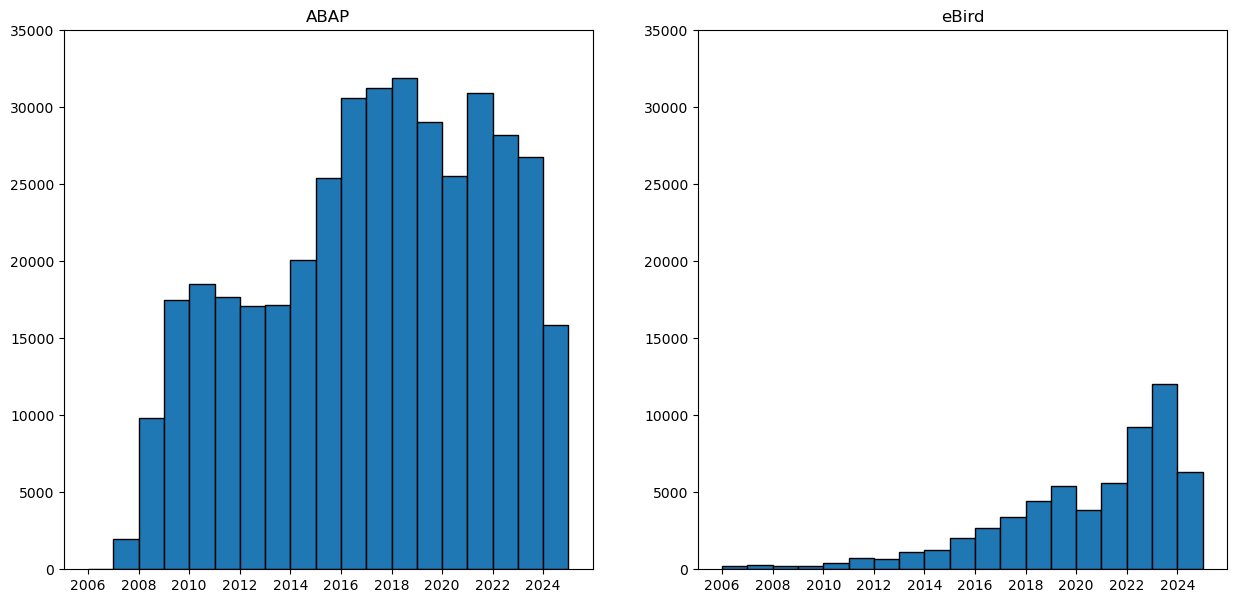

In [125]:
def plot_map(ax, c, title):
    y = pd.to_datetime(c["startdate"]).dt.year
    ax.hist(
        y,
        bins=np.arange(2006, np.max(y) + 2, 1),
        edgecolor="black",
    )
    ax.set_ylim(0, 35000)
    ax.set_title(title)
    ax.set_xticks(np.arange(2006, 2025, 2))


fig, axs = plt.subplots(1, 2, figsize=(15, 7))

# Plot both maps
plot_map(axs[0], ac, "ABAP")
plot_map(axs[1], ec, "eBird")

# plt.subplots_adjust(wspace=0)
plt.show()

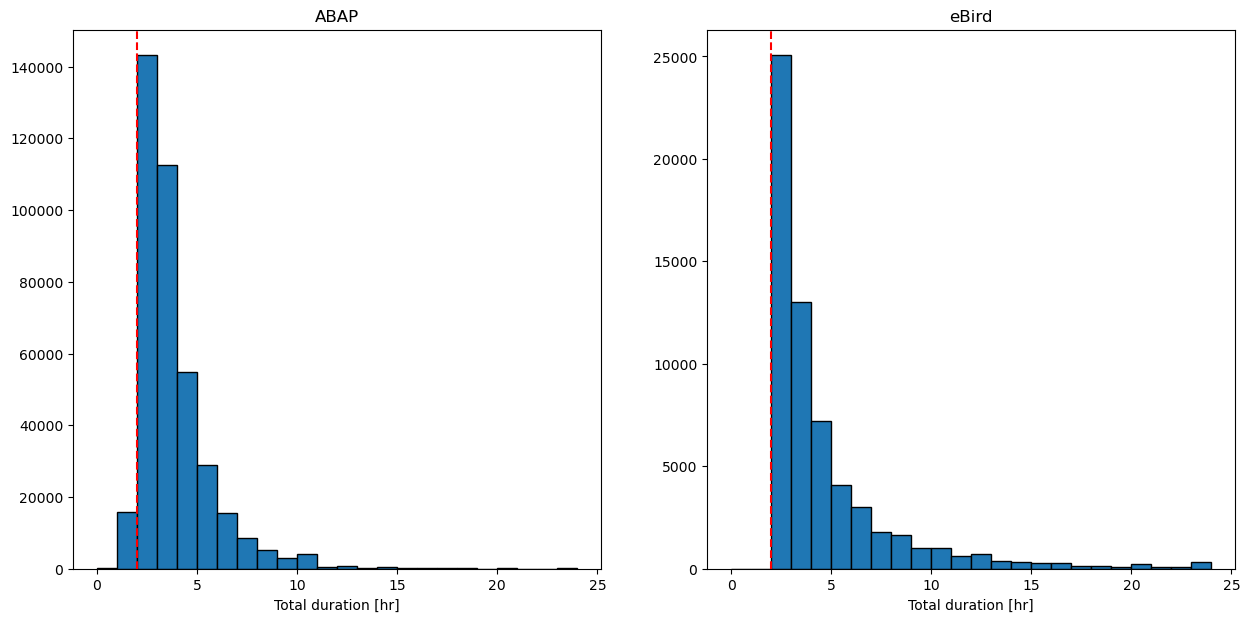

In [190]:
def plot_map(ax, c, title):
    # ax.hist(c["totalhours"], bins=np.arange(0, 350, 1), edgecolor="black", log=True)
    ax.hist(c["totalhours"], bins=np.arange(0, 25, 1), edgecolor="black")
    ax.set_title(title)
    ax.axvline(x=2, color="red", linestyle="--")
    ax.set_xlabel("Total duration [hr]")
    # ax.set_xticks(np.arange(2006, 2025, 2))


fig, axs = plt.subplots(1, 2, figsize=(15, 7))

# Plot both maps
plot_map(axs[0], ac, "ABAP")
plot_map(axs[1], ec, "eBird")

# plt.subplots_adjust(wspace=0)
plt.show()

In [136]:
ec[ec["totalhours"] > 100]

,card,SAMPLING EVENT IDENTIFIER_list,OBSERVATION DATETIME_min,OBSERVATION DATETIME_max,DURATION MINUTES_sum,EFFORT DISTANCE KM_sum,pentad,OBSERVER ID,startdate,totalhours,lat,lon
36045,2010_2830_r757877_20200512,"['S68973252', 'S68973193', 'S68976322', 'S6903...",2020-05-12 06:13:00,2020-05-14 17:14:00,9366.0,0.000,2010_2830,obsr757877,2020-05-12,156.100000,-20.208333,28.541667
36048,2010_2830_r757877_20200528,"['S69741453', 'S70035315', 'S69839040', 'S6984...",2020-05-28 06:56:00,2020-05-31 16:29:00,10080.0,0.000,2010_2830,obsr757877,2020-05-28,168.000000,-20.208333,28.541667
46843,2650_2640_r1074716_20180427,"['S44989990', 'S45174346', 'S45174348', 'S4517...",2018-04-27 08:00:00,2018-04-29 16:25:00,12795.0,0.000,2650_2640,obsr1074716,2018-04-27,213.250000,-26.875000,26.708333
54618,3235_1900_r613547_20190408,['S55157002'],2019-04-08 09:52:00,2019-04-08 09:52:00,14000.0,3.219,3235_1900,obsr613547,2019-04-08,233.333333,-32.625000,19.041667


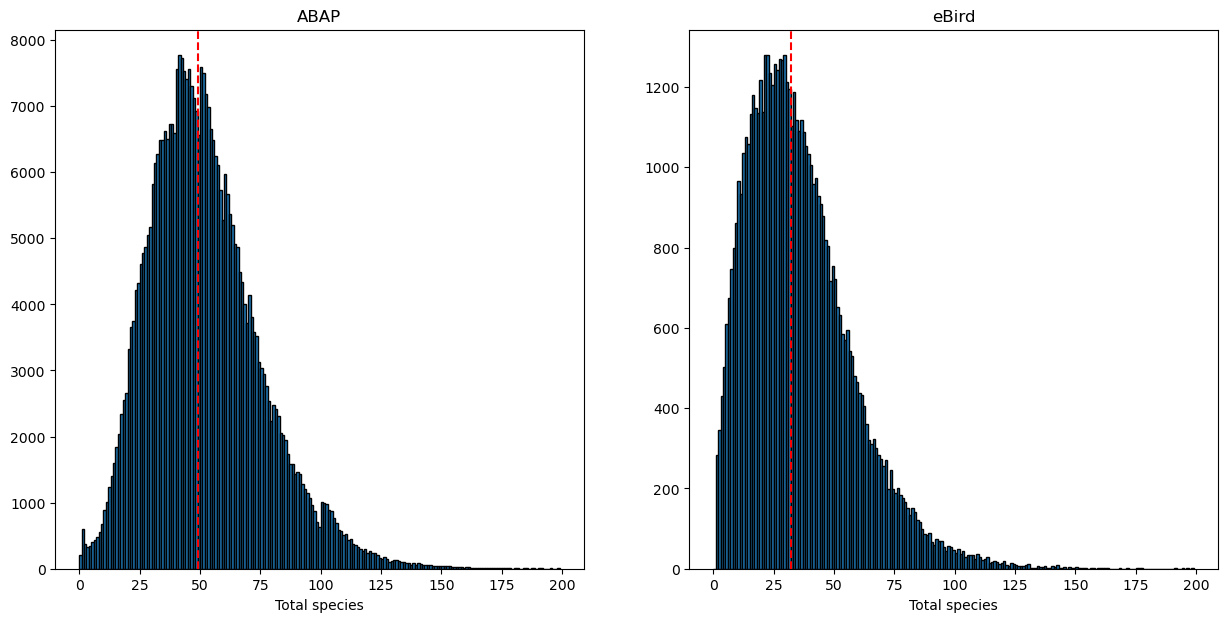

In [188]:
def plot_map(ax, c, title):
    # ax.hist(c["totalspp"], bins=np.arange(0, 300, 1), edgecolor="black", log=True)
    ax.hist(c["totalspp"], bins=np.arange(0, 200, 1), edgecolor="black")
    ax.axvline(x=np.median(c["totalspp"]), color="red", linestyle="--")
    ax.set_title(title)
    ax.set_xlabel("Total species")
    # ax.set_xticks(np.arange(2006, 2025, 2))


fig, axs = plt.subplots(1, 2, figsize=(15, 7))

# Plot both maps
plot_map(axs[0], ac, "ABAP")
plot_map(axs[1], ec, "eBird")

# plt.subplots_adjust(wspace=0)
plt.show()

In [187]:
ec[ec["totalspp"] < 2]

,card,SAMPLING EVENT IDENTIFIER_list,pentad,OBSERVER ID,startdate,totalhours,lat,lon,species_count,totalspp
188,0005_3000_r1194784_20220220,['S103241589'],0005_3000,obsr1194784,2022-02-20,5.833333,-0.125000,30.041667,1,1
290,0005_3000_r534420_20140815,['S19570399'],0005_3000,obsr534420,2014-08-15,3.000000,-0.125000,30.041667,1,1
370,0005_3440_r1715259_20181014,['S69195508'],0005_3440,obsr1715259,2018-10-14,2.000000,-0.125000,34.708333,1,1
1050,0005c3225_r1962437_20191011,['S77255481'],0005c3225,obsr1962437,2019-10-11,2.000000,0.041667,32.458333,1,1
1703,0005c3225_r668510_20181011,['S49633559'],0005c3225,obsr668510,2018-10-11,2.000000,0.041667,32.458333,1,1
...,...,...,...,...,...,...,...,...,...,...
60657,3420_1825_r1101124_20170705,['S47771103'],3420_1825,obsr1101124,2017-07-05,10.000000,-34.375000,18.458333,1,1
60719,3420_1825_r2915149_20191029,['S130249111'],3420_1825,obsr2915149,2019-10-29,2.000000,-34.375000,18.458333,1,1
60783,3420_1825_r88127_20130104,['S14210192'],3420_1825,obsr88127,2013-01-04,2.000000,-34.375000,18.458333,1,1
61706,3520b0535_r195106_20221012,['S120945072'],3520b0535,obsr195106,2022-10-12,2.000000,35.291667,-5.541667,1,1
